In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

CK_metrics = ['CBO', 'FAN_IN', 'FAN_OUT','DIT','NOC','LCOM','TCC','LCC']
CK_df_metrics=['cbo', 'fanin', 'fanout','dit','noc','lcom','tcc','lcc']

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [ ]:
data_adver = pd.read_csv('./datasets/data_adver.csv')

data_not_adver = pd.read_csv('./datasets/data_not_adver.csv')

data_adver_diff = pd.read_csv('./datasets/data_adver_diff.csv')

data_not_adver_diff = pd.read_csv('./datasets/data_not_adver_diff.csv')

In [ ]:
merged_data = pd.concat([data_adver, data_not_adver], ignore_index=True)

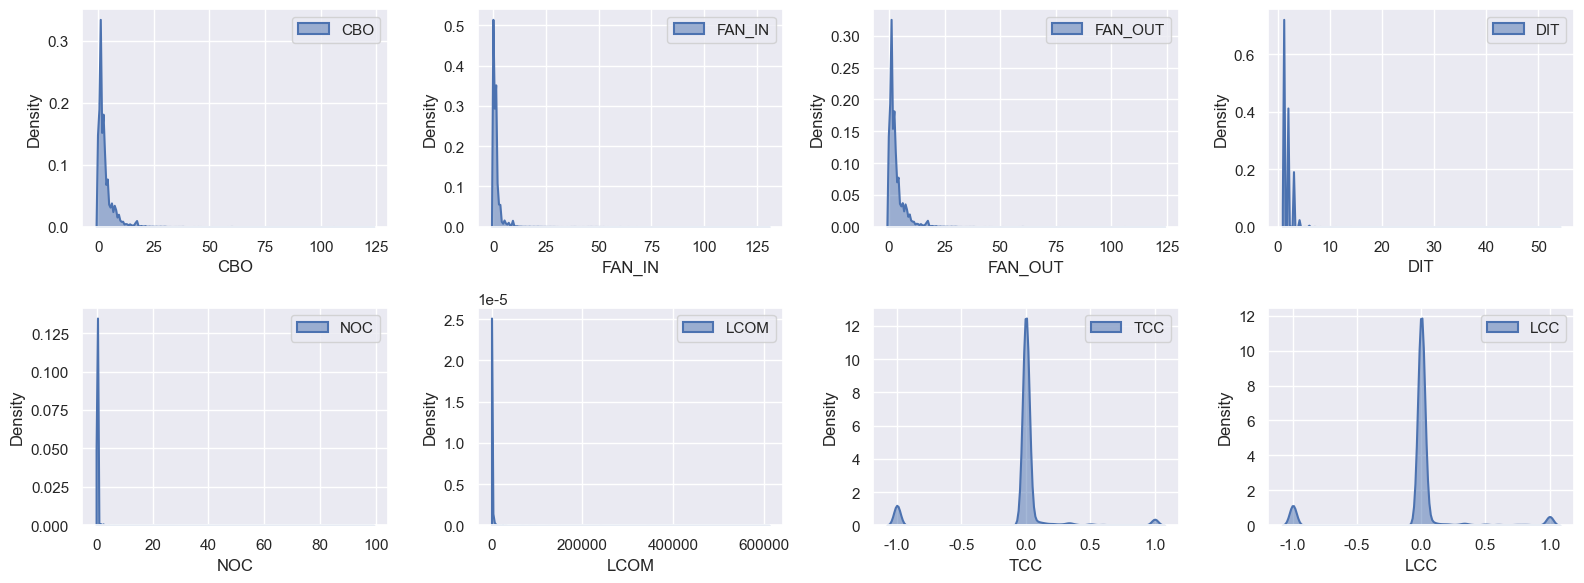

In [ ]:

sns.set_theme(style="darkgrid")

def plot_ridge_plot(data, metrics):
    num_plots = len(metrics)
    nrows = 2
    ncols = 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    
    if nrows == 1:
        axes = [axes]
    
    for i, metric in enumerate(metrics):
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        
        sns.kdeplot(data[metric], fill=True, alpha=0.5, linewidth=1.5, label=metric, ax=ax)
        #ax.set_title(f'Distribution of {metric}')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    

    plt.savefig('ridge_plots.pdf', bbox_inches='tight')
    plt.show()

plot_ridge_plot(merged_data, CK_metrics) 

In [ ]:
def draw_plot_raincloud(data1, data2, metrics, categories, colors_box=['yellowgreen', 'olivedrab'], colors_violin=['thistle', 'orchid'], colors_scatter=['tomato', 'darksalmon'], title='默认标题'):
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)

    df1['category'] = categories[0]
    df2['category'] = categories[1]

    df = pd.concat([df1, df2])
    df = df.reset_index(drop=True)
    df.fillna(0, inplace=True)

    num_plots = len(metrics)
    nrows = (num_plots - 1) // 4 + 1  
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(18, 4 * nrows))

    if nrows == 1:
        axes = [axes] 

    for i, metric in enumerate(metrics):
        row = i // 4
        col = i % 4
        ax = axes[row][col]

        data_x = [df[df['category'] == categories[0]][metric], df[df['category'] == categories[1]][metric]]

        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[0.5, 1.5],showfliers=False)
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set(facecolor=color, alpha=0.4)

        for median, color in zip(bp['medians'], colors_box): 
            median.set(color=color, linewidth=2)
        '''
        
        # Boxenplot
        sns.boxenplot(x=metric, y='category', data=df, order=categories, palette=dict(zip(categories, colors_box)), ax=ax)
        '''
        # Violinplot
        vp = ax.violinplot(data_x, showmeans=False, showextrema=False, showmedians=False, vert=False, positions=[0.5, 1.5])
        for idx, b in enumerate(vp['bodies']):
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx + 0.5, idx + 1.5)
            b.set_color(colors_violin[idx])

        # Scatterplot
        for idx, features in enumerate(data_x):
            y = np.full(len(features), idx + 0.3)
            idxs = np.arange(len(y))
            out = y.astype(float)
            out.flat[idxs] += np.random.uniform(low=-0.05, high=0.05, size=len(idxs))
            ax.scatter(features, out, s=1, c=colors_scatter[idx])

        ax.set_yticks([0.5, 1.5])
        ax.set_yticklabels(categories)
        ax.set_xlabel('Values')
        ax.set_title(f'{metric}')


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{title}.svg', format='svg')
    plt.show()

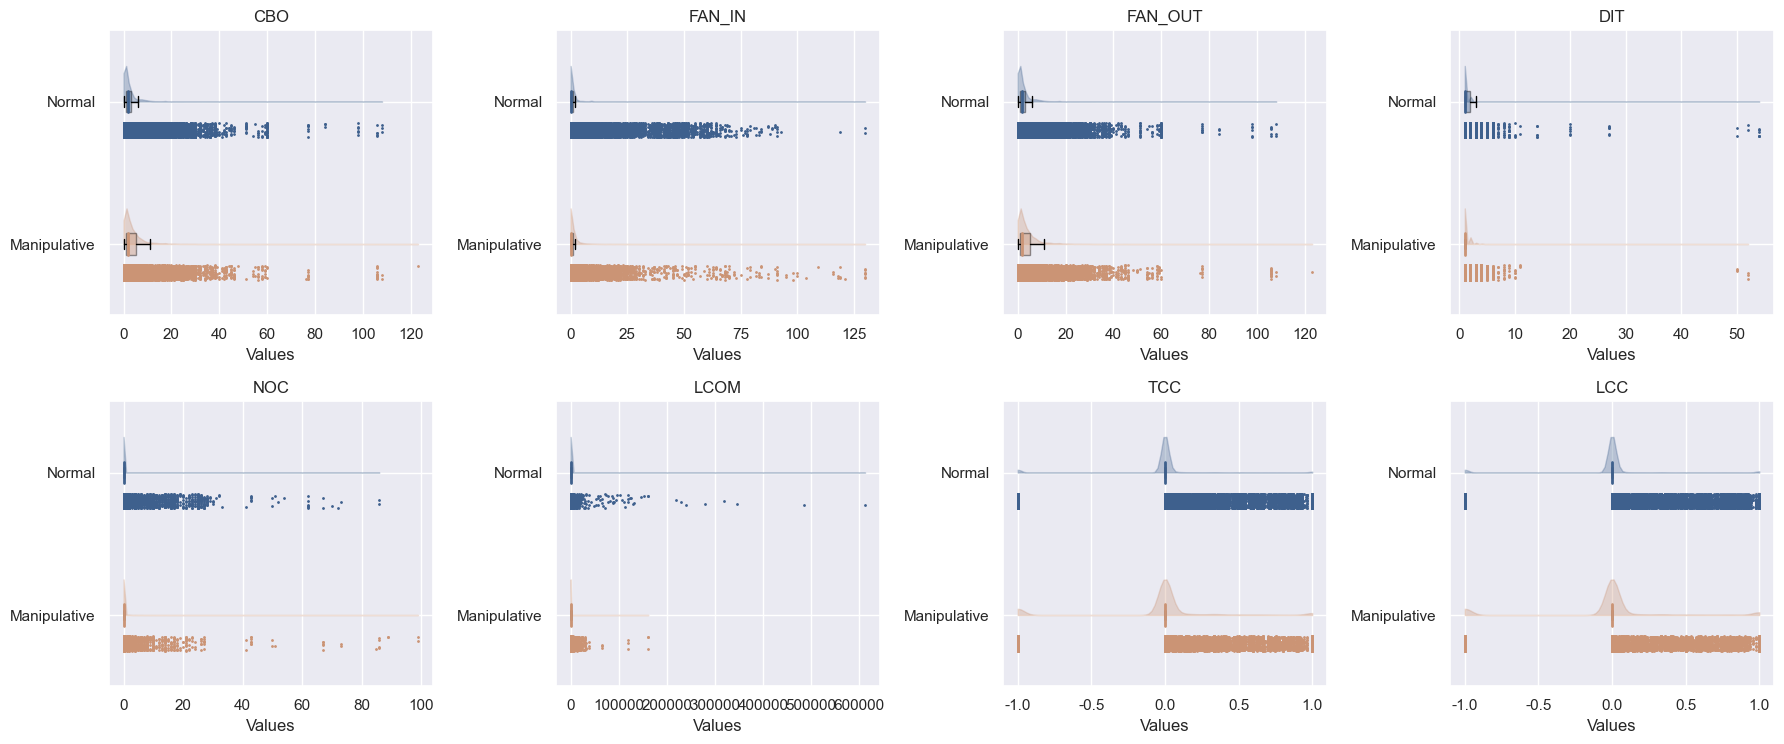

In [6]:
draw_plot_raincloud(data_adver,data_not_adver,CK_metrics,['Manipulative','Normal'],colors_box=['#CB9475', '#3E608D'], colors_violin=['#CB9475', '#3E608D'], colors_scatter=['#CB9475', '#3E608D'], title='rq2_quality_evolution_original')

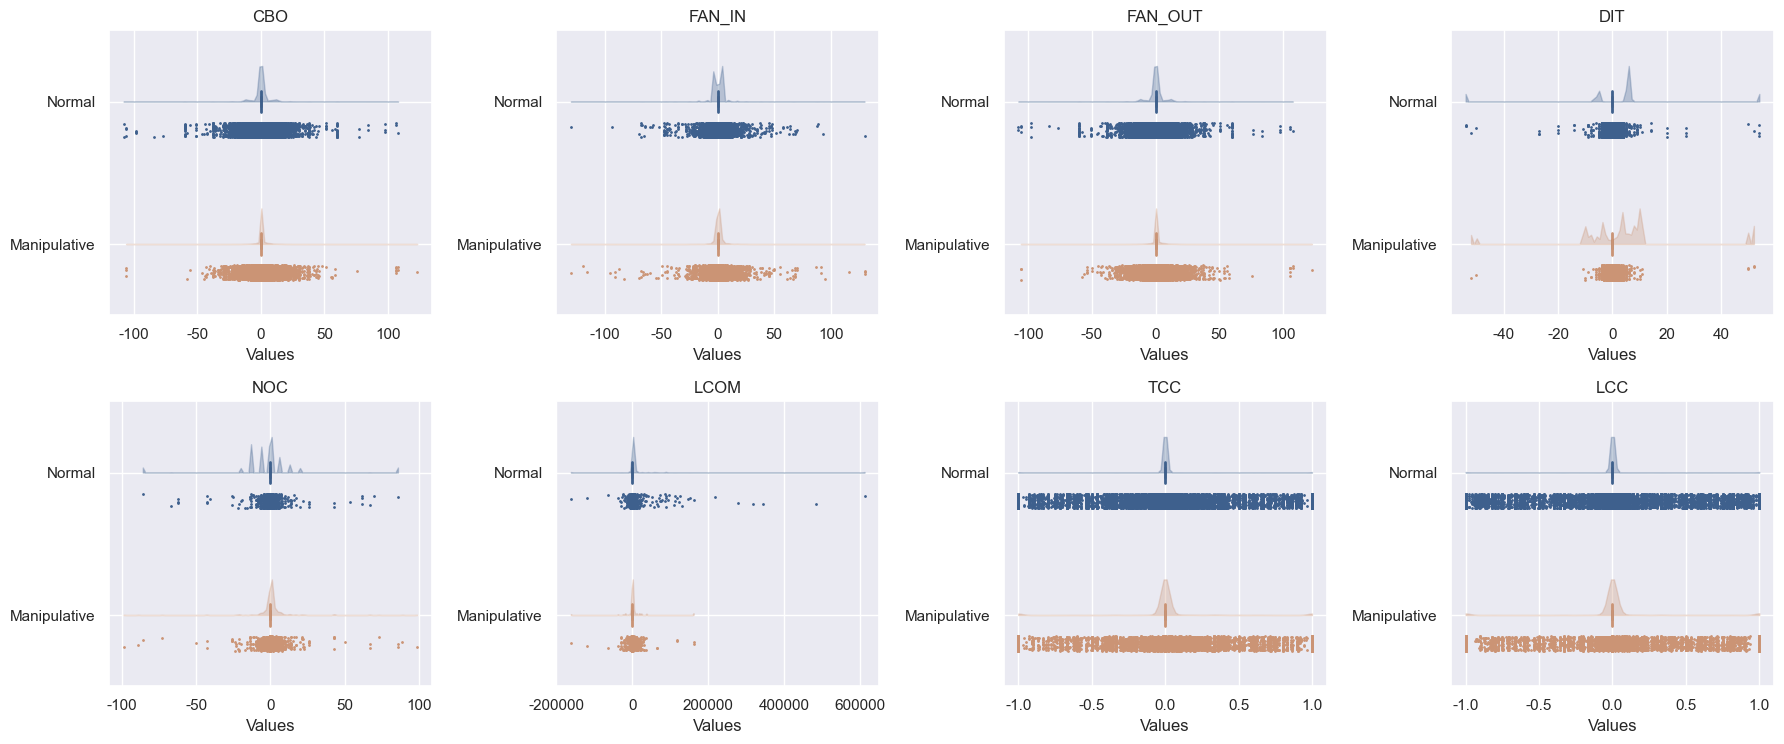

In [7]:
draw_plot_raincloud(data_adver_diff,data_not_adver_diff,CK_metrics,['Manipulative','Normal'],colors_box=['#CB9475', '#3E608D'], colors_violin=['#CB9475', '#3E608D'], colors_scatter=['#CB9475', '#3E608D'], title='rq2_quality_evolution_deff')

In [ ]:
from scipy.stats import mannwhitneyu, ks_2samp

tj_dict = []
tj_diff_dict = []

for metric in CK_metrics:
    group1 = data_adver[metric]
    group2 = data_not_adver[metric]
    
    MWU_stat, MWU_p_value = mannwhitneyu(group1, group2)
    KS_stat, KS_p_value = ks_2samp(group1, group2)

    MWU_dif = MWU_p_value < 0.05
    KS_dif = KS_p_value < 0.05

    tj_dict.append({
        'metric': metric,
        'MWU_p_value': MWU_p_value,
        'KS_p_value': KS_p_value,
        'MWU_dif': MWU_dif,
        'KS_dif': KS_dif,
        'MWU_stat': MWU_stat,
        'KS_stat': KS_stat,
        'data_type': 'original'
    })

for metric in CK_metrics:
    group1 = data_adver_diff[metric]
    group2 = data_not_adver_diff[metric]

    MWU_stat, MWU_p_value = mannwhitneyu(group1, group2)
    KS_stat, KS_p_value = ks_2samp(group1, group2)

    MWU_dif = MWU_p_value < 0.05
    KS_dif = KS_p_value < 0.05

    tj_diff_dict.append({
        'metric': metric,
        'MWU_p_value': f"{MWU_p_value:.4f}",
        'KS_p_value': f"{KS_p_value:.4f}",
        'MWU_dif': MWU_dif,
        'KS_dif': KS_dif,
        'MWU_stat': MWU_stat,
        'KS_stat': KS_stat,
        'data_type': 'differenced'
    })

df_tj = pd.DataFrame(tj_dict)
df_tj_diff = pd.DataFrame(tj_diff_dict)

df_combined = pd.concat([df_tj, df_tj_diff], ignore_index=True)

print("Combined Test Results:")
print(df_combined.to_string(index=False))

Combined Test Results:
 metric MWU_p_value KS_p_value  MWU_dif  KS_dif     MWU_stat  KS_stat   data_type
    CBO         0.0        0.0     True    True 1.330852e+10 0.122049    original
 FAN_IN     0.32495        0.0    False    True 1.153374e+10 0.021987    original
FAN_OUT         0.0        0.0     True    True 1.340681e+10 0.127032    original
    DIT         0.0        0.0     True    True 1.108538e+10 0.049011    original
    NOC    0.000021   0.211924     True   False 1.158489e+10 0.004212    original
   LCOM         0.0        0.0     True    True 1.297033e+10 0.119532    original
    TCC         0.0        0.0     True    True 1.169215e+10 0.073492    original
    LCC         0.0        0.0     True    True 1.169145e+10 0.073492    original
    CBO      0.0000     0.0000     True    True 1.231770e+10 0.137577 differenced
 FAN_IN      0.0000     0.0000     True    True 1.205596e+10 0.098710 differenced
FAN_OUT      0.0000     0.0000     True    True 1.231333e+10 0.137934 diffe

In [9]:
Exponential_metrics = ['DIT','NOC','LCOM']
Gaussian_metrics = ['CBO', 'FAN_IN', 'FAN_OUT','TCC','LCC']
Exponential_importance=[0.057,0.020,0.058]
Gaussian_importance=[0.072,0.081,0.043,0.008,0.051]
all_importance=[0.072,0.081,0.043,0.057,0.020,0.058,0.008,0.051]

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

scores_dict={}
scores_dict_not={}

def exponential_c_λ(data):
    hist, bin_edges =  np.histogram(data, bins='auto')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def exponential_pdf(x, c, lambda_):
        return np.where(x > c, lambda_ * np.exp(-lambda_ * (x - c)), 0)

    popt, pcov = curve_fit(exponential_pdf, bin_centers, hist)
    return popt[0],popt[1]

def exponential_scores(normalized_data, c, lambda_):
    scores = []
    for x in normalized_data:
        if x <= c:
            score = 100
        else:
            probability = lambda_ * np.exp(-lambda_ * (x - c))
            score = 100 * probability
        scores.append(score)
    return scores


for metric in Exponential_metrics:
    list1=data_adver[metric].to_list()
    list2=data_not_adver[metric].to_list()
    data = list1+list2
    print(metric,len(data))
    c,λ=exponential_c_λ(data)
    scores_dict[metric]= exponential_scores(list1, c, λ)
    scores_dict_not[metric]= exponential_scores(list2, c, λ)
    print(metric,c,λ)

DIT 366004
DIT 1.0113135496633496 1.0200482139281613
NOC 366004


C:\Users\lenovo\AppData\Local\Temp\ipykernel_15940\1588313909.py:15: RuntimeWarning: overflow encountered in exp
  return np.where(x > c, lambda_ * np.exp(-lambda_ * (x - c)), 0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15940\1588313909.py:15: RuntimeWarning: overflow encountered in multiply
  return np.where(x > c, lambda_ * np.exp(-lambda_ * (x - c)), 0)


NOC 2.4749853168833345 18.482920386055973
LCOM 366004


c:\Users\lenovo\anaconda3\envs\adversarial_action\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
c:\Users\lenovo\anaconda3\envs\adversarial_action\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


LCOM 1.0 1.0


In [ ]:
import math
def gaussian_μ_σ1_σ2(data):
    hist, bin_edges =  np.histogram(data, bins='auto')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gauss_pdf(x, mu, sigma1, sigma2):
        condition = x >= mu
        result = np.zeros_like(x)
        
        result[condition] = (1 / np.sqrt(2 * np.pi)) * (2 / (sigma1 + sigma2)) * np.exp(-(x[condition] - mu)**2 / (2 * sigma2**2))
        result[~condition] = (1 / np.sqrt(2 * np.pi)) * (2 / (sigma1 + sigma2)) * np.exp(-(x[~condition] - mu)**2 / (2 * sigma1**2))
        
        return result

    popt, pcov = curve_fit(gauss_pdf, bin_centers, hist)
    return popt[0],popt[1],popt[2]

def gaussian_scores(data, mu, sigma1, sigma2):
    scores=[]
    for x in data:
        erf_term_left = 1 - math.erf((x - mu) / (sigma1 * math.sqrt(2)))
        erf_term_right = 1 - math.erf((x - mu) / (sigma2 * math.sqrt(2)))

        if x <= mu:
            scores.append(100 * erf_term_left)
        else:
            scores.append(100 * erf_term_right)
    return scores

for metric in Gaussian_metrics:
    list1=data_adver[metric].to_list()
    list2=data_not_adver[metric].to_list()
    data = list1+list2
    print(metric,len(data))
    μ,σ1,σ2=gaussian_μ_σ1_σ2(data)
    print(μ,σ1,σ2)
    scores_dict[metric]= gaussian_scores(list1, μ,σ1,σ2)
    scores_dict_not[metric]= gaussian_scores(list2, μ,σ1,σ2)

CBO 366004
0.9641949214241284 -0.018166801241992606 0.018174875665104593
FAN_IN 366004
0.9924678759727599 -0.012015609501661669 0.01202361662491101
FAN_OUT 366004
0.9641945606087559 -0.017757595845540614 0.017765732775841318
TCC 366004
0.0712915588075602 0.026586863602453697 -0.026584985164692786
LCC 366004
0.06995527520557039 0.025956239520105978 -0.025954308281953904


[0.1846153846153846, 0.2076923076923077, 0.11025641025641024, 0.14615384615384616, 0.05128205128205128, 0.14871794871794872, 0.020512820512820513, 0.13076923076923075]


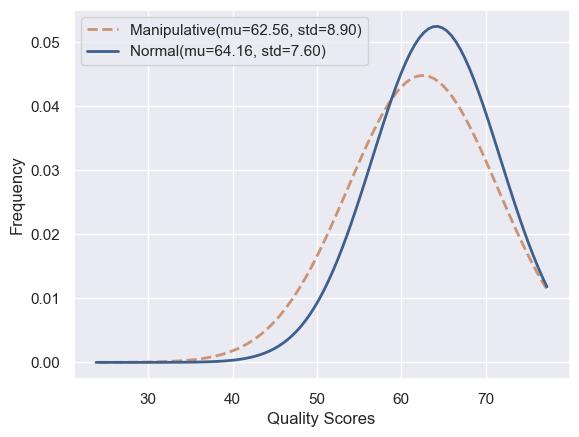

In [ ]:
from scipy.stats import norm

total = sum(all_importance)

normalized_values = [value / total for value in all_importance]

print(normalized_values)

result = [0] * len(scores_dict[next(iter(scores_dict))])
for metric, importance in zip(CK_metrics, normalized_values):
    scores = scores_dict[metric]
    weighted_scores = [score * importance for score in scores]
    result = [x + y for x, y in zip(result, weighted_scores)]

result2 = [0] * len(scores_dict_not[next(iter(scores_dict_not))])
for metric, importance in zip(CK_metrics, normalized_values):
    scores = scores_dict_not[metric]
    weighted_scores = [score * importance for score in scores]
    result2 = [x + y for x, y in zip(result2, weighted_scores)]

mu, std = norm.fit(result)
xmin, xmax = min(result), max(result)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', color='#CB9475',linewidth=2, label=f'Manipulative(mu={mu:.2f}, std={std:.2f})')  # 黑色实线

mu2, std2 = norm.fit(result2)
xmin2, xmax2 = min(result2), max(result2)
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
plt.plot(x2, p2, '-', color='#3E608D',linewidth=2, label=f'Normal(mu={mu2:.2f}, std={std2:.2f})')  # 红色虚线

plt.legend()


#plt.title('Comparison of Two Datasets with Normal Distribution Fits')
plt.xlabel('Quality Scores')
plt.ylabel('Frequency')

plt.savefig('comparison_distribution_fits.pdf', bbox_inches='tight')


plt.show()

In [ ]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as np2ri
import numpy as np

np2ri.activate()
ro.r('library(effsize)')

for metric in CK_metrics:
    group1 = data_adver[metric].to_numpy()
    group2 = data_not_adver[metric].to_numpy()


    ro.globalenv['group1'] = group1
    ro.globalenv['group2'] = group2

    result = ro.r('effsize::VD.A(group1, group2)')
    print(f"{metric} Vargha-Delaney A^12效应量: {result[3][0]}")


CBO Vargha-Delaney A^12效应量: 0.5757400540689653
FAN_IN Vargha-Delaney A^12效应量: 0.4989613741205174
FAN_OUT Vargha-Delaney A^12效应量: 0.5799923569647812
DIT Vargha-Delaney A^12效应量: 0.4795647503167984
NOC Vargha-Delaney A^12效应量: 0.5011743210935516
LCOM Vargha-Delaney A^12效应量: 0.5611097142659601
TCC Vargha-Delaney A^12效应量: 0.5058144055454618
LCC Vargha-Delaney A^12效应量: 0.5057842408438445


In [ ]:
for metric in CK_metrics:
    group1 = data_adver_diff[metric].to_numpy()
    group2 = data_not_adver_diff[metric].to_numpy()


    ro.globalenv['group1'] = group1
    ro.globalenv['group2'] = group2

    result = ro.r('effsize::VD.A(group1, group2)')
    print(f"{metric} Vargha-Delaney A^12效应量: {result[3][0]}")

CBO Vargha-Delaney A^12效应量: 0.5328764828855044
FAN_IN Vargha-Delaney A^12效应量: 0.5215531284415313
FAN_OUT Vargha-Delaney A^12效应量: 0.5326873642636014
DIT Vargha-Delaney A^12效应量: 0.5356645291882062
NOC Vargha-Delaney A^12效应量: 0.5013371617141313
LCOM Vargha-Delaney A^12效应量: 0.5168490300881248
TCC Vargha-Delaney A^12效应量: 0.5072342218826409
LCC Vargha-Delaney A^12效应量: 0.5071771074224998
